# 01 – Credit Risk Data EDA & Naive Bayes

Энэ notebook нь Kaggle-ийн **Credit Risk Dataset** дээр EDA хийж, Naive Bayes моделийг сургаж, үнэлгээ хийхэд зориулагдсан.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    classification_report,
)

%matplotlib inline
sns.set(style='whitegrid')

# Ensure output folders
os.makedirs('../outputs', exist_ok=True)
os.makedirs('../outputs/figures', exist_ok=True)


## II. Өгөгдөл унших, анхны шалгалт

In [3]:
# === CSV унших ===
data_path = "../data/credit_risk_dataset.csv"  # хэрэгтэй бол өөрчлөх
df = pd.read_csv(data_path)

print('Shape:', df.shape)
df.head()

Shape: (32581, 12)


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [4]:
# Өгөгдлийн бүтцийг шалгах
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [16]:
# Тоон багануудын үндсэн статистик
df.describe().T

,count,mean,std,min,25%,50%,75%,max
person_age,32581.0,27.734600,6.348078,20.00,23.00,26.00,30.00,144.00
person_income,32581.0,66074.848470,61983.119168,4000.00,38500.00,55000.00,79200.00,6000000.00
person_emp_length,31686.0,4.789686,4.142630,0.00,2.00,4.00,7.00,123.00
loan_amnt,32581.0,9589.371106,6322.086646,500.00,5000.00,8000.00,12200.00,35000.00
loan_int_rate,29465.0,11.011695,3.240459,5.42,7.90,10.99,13.47,23.22
loan_status,32581.0,0.218164,0.413006,0.00,0.00,0.00,0.00,1.00
loan_percent_income,32581.0,0.170203,0.106782,0.00,0.09,0.15,0.23,0.83
cb_person_cred_hist_length,32581.0,5.804211,4.055001,2.00,3.00,4.00,8.00,30.00


In [17]:
# Дутуу утга (NA) шалгах
df.isnull().sum().sort_values(ascending=False)

loan_int_rate                 3116
person_emp_length              895
person_age                       0
person_income                    0
person_home_ownership            0
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

## Target багана тодорхойлох (default 0/1 болгох)

Доорх `TARGET_COL`-ын утгыг dataset доторх зорилтот баганын нэрээр солиж болно.
Жишээ нь: `default` эсвэл `loan_status` гэх мэт.

In [ ]:
TARGET_COL = 'loan_status'

if TARGET_COL not in df.columns:
    raise ValueError(f"TARGET_COL='{TARGET_COL}' багана олдсонгүй. Боломжит баганууд: {df.columns.tolist()}")

y_raw = df[TARGET_COL].copy()
print('Target type:', y_raw.dtype)
print('Target unique values:', y_raw.unique())

Target type: int64
Target unique values: [1 0]


In [9]:
# Target-ыг 0/1 болгох (ерөнхий хувилбар)

y = y_raw.copy()

if y.dtype == 'O':
    # String төрөл бол Yes/No, True/False гэх мэтийг 0/1 болгоно
    y_clean = y.astype(str).str.strip().str.lower()
    mapping = {
        'yes': 1, 'y': 1, 'true': 1, '1': 1, 'default': 1,
        'no': 0, 'n': 0, 'false': 0, '0': 0, 'non-default': 0
    }

    if set(y_clean.unique()) <= set(mapping.keys()):
        y = y_clean.map(mapping)
    else:
        print('⚠️ Target баганын утгууд автоматаар map хийхэд тохирохгүй байна.')
        print('Та дараах утгуудыг гараар map хийх шаардлагатай байж магадгүй:')
        print(sorted(y_clean.unique()))
        # Энд гараар mapping хийнэ
        # Жишээ: y = y_clean.map({'good':0, 'bad':1})

else:
    # Хэрэв тоон ба 0/1 биш байвал өөрөө шалгаж тохируулах
    print('Target already numeric. Unique values:', sorted(y.unique()))

# Target-ыг df дээр numeric хувилбараар хадгалъя
df[TARGET_COL + '_bin'] = y
TARGET_BIN_COL = TARGET_COL + '_bin'

print('Binary target column:', TARGET_BIN_COL)
print(df[TARGET_BIN_COL].value_counts(dropna=False))

Target already numeric. Unique values: [np.int64(0), np.int64(1)]
Binary target column: loan_status_bin
loan_status_bin
0    25473
1     7108
Name: count, dtype: int64


## V. EDA – Target class balance

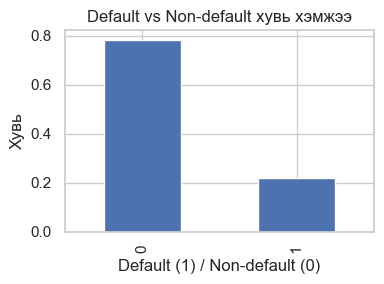

In [10]:
# Class balance
plt.figure(figsize=(4,3))
df[TARGET_BIN_COL].value_counts(normalize=True).plot(kind='bar')
plt.title('Default vs Non-default хувь хэмжээ')
plt.xlabel('Default (1) / Non-default (0)')
plt.ylabel('Хувь')
plt.tight_layout()
plt.savefig('../outputs/figures/class_balance.png')
plt.show()

## III. Өгөгдөл цэвэрлэх (тоон / ангилал, NA бөглөх, encoding)

In [11]:
# Target-оос бусад багануудыг feature гэж үзнэ
feature_cols = [c for c in df.columns if c not in [TARGET_COL, TARGET_BIN_COL]]
df_features = df[feature_cols].copy()

# Тоон багана
num_cols = df_features.select_dtypes(include=['int64', 'float64']).columns.tolist()
# Ангилал багана
cat_cols = df_features.select_dtypes(include=['object']).columns.tolist()

print('Numeric columns:', num_cols)
print('Categorical columns:', cat_cols)

Numeric columns: ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
Categorical columns: ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file', 'loan_grade_bin']


In [14]:
# Тоон багануудын NA-г median-ээр бөглөх
for col in num_cols:
    median_val = df_features[col].median()
    df_features[col].fillna(median_val, inplace=True)

# Ангилал багануудын NA-г mode эсвэл 'Unknown'-оор
for col in cat_cols:
    if df_features[col].isnull().any():
        mode_val = df_features[col].mode()[0]
        df_features[col].fillna(mode_val, inplace=True)

# Хэт их NA-тэй багана байгаа эсэхийг анх шалгаад шийдвэр гаргах жишээ:
na_rate = df.isnull().mean().sort_values(ascending=False)
print('NA rate by column:')
print(na_rate.head(10))

NA rate by column:
loan_int_rate            0.095639
person_emp_length        0.027470
person_age               0.000000
person_income            0.000000
person_home_ownership    0.000000
loan_intent              0.000000
loan_grade               0.000000
loan_amnt                0.000000
loan_status              0.000000
loan_percent_income      0.000000
dtype: float64


/var/folders/0d/c7wyp66j1cj21499sph8z4700000gn/T/ipykernel_10760/1636917161.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_features[col].fillna(median_val, inplace=True)
/var/folders/0d/c7wyp66j1cj21499sph8z4700000gn/T/ipykernel_10760/1636917161.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alw

In [15]:
# One-hot encoding (categorical багануудыг dummy хувьсагч болгох)
df_encoded = pd.get_dummies(df_features, columns=cat_cols, drop_first=True)
print('Encoded shape:', df_encoded.shape)
df_encoded.head()

Encoded shape: (32581, 28)


,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,...,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_Y,loan_grade_bin_B,loan_grade_bin_C,loan_grade_bin_D,loan_grade_bin_E,loan_grade_bin_F,loan_grade_bin_G
0,22,59000,123.0,35000,16.02,0.59,3,False,False,True,...,False,False,False,True,False,False,True,False,False,False
1,21,9600,5.0,1000,11.14,0.10,2,False,True,False,...,False,False,False,False,True,False,False,False,False,False
2,25,9600,1.0,5500,12.87,0.57,3,False,False,False,...,False,False,False,False,False,True,False,False,False,False
3,23,65500,4.0,35000,15.23,0.53,2,False,False,True,...,False,False,False,False,False,True,False,False,False,False
4,24,54400,8.0,35000,14.27,0.55,4,False,False,True,...,False,False,False,True,False,True,False,False,False,False


## IV. Train/Test Split ба Scaling

In [16]:
# Feature matrix (X) болон target vector (y)
X = df_encoded.values
y = df[TARGET_BIN_COL].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print('Train shape:', X_train.shape)
print('Test shape:', X_test.shape)

Train shape: (26064, 28)
Test shape: (6517, 28)


In [17]:
# StandardScaler ашиглан scaling хийх
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled[:5]

array([[-0.42716311,  2.75966614, -0.18763034,  1.02145474, -1.28839641,
        -0.93795613, -0.44281673, -0.05853522, -0.29525883, -1.01282005,
         2.00838336, -0.35224728, -0.48080785, -0.44931214, -0.46122697,
        -0.68511879, -0.50115075, -0.35210964, -0.17459308, -0.08682154,
        -0.04112185, -0.4636108 , -0.68511879, -0.50115075, -0.35210964,
        -0.17459308, -0.08682154, -0.04112185],
       [-1.05935771, -0.75404017,  0.05538284, -1.28166412,  0.37932712,
        -0.84432792, -0.44281673, -0.05853522, -0.29525883,  0.98734223,
        -0.49791291, -0.35224728, -0.48080785,  2.22562427, -0.46122697,
         1.4596009 , -0.50115075, -0.35210964, -0.17459308, -0.08682154,
        -0.04112185, -0.4636108 ,  1.4596009 , -0.50115075, -0.35210964,
        -0.17459308, -0.08682154, -0.04112185],
       [-0.42716311, -0.20471702,  1.27044871,  1.02145474,  0.49310942,
         1.21549281, -0.93851434, -0.05853522, -0.29525883, -1.01282005,
        -0.49791291, -0.3522

## V. EDA – Тоон болон ангилал хувьсагчийн дүрслэл

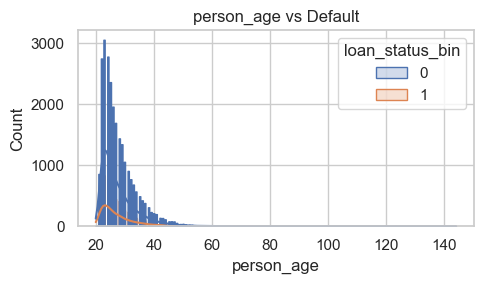

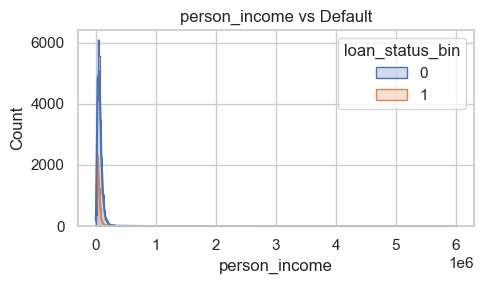

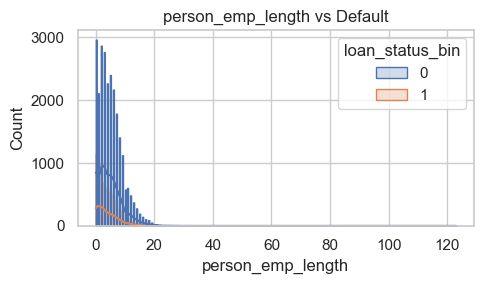

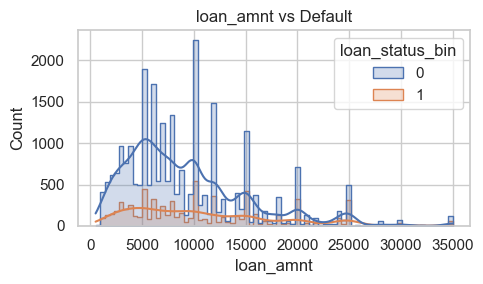

In [18]:
# Тоон хувьсагчийн histogram (хэрэв байвал)
num_cols_for_plot = num_cols[:4]  # Хэт олон байвал эхний хэд дээр

for col in num_cols_for_plot:
    plt.figure(figsize=(5,3))
    sns.histplot(data=df, x=col, hue=TARGET_BIN_COL, kde=True, element='step')
    plt.title(f'{col} vs Default')
    plt.tight_layout()
    plt.savefig(f'../outputs/figures/hist_{col}.png')
    plt.show()


Cross-tab for person_home_ownership:


loan_status_bin,0,1
person_home_ownership,,
MORTGAGE,0.874293,0.125707
OTHER,0.691589,0.308411
OWN,0.925310,0.074690
RENT,0.684300,0.315700


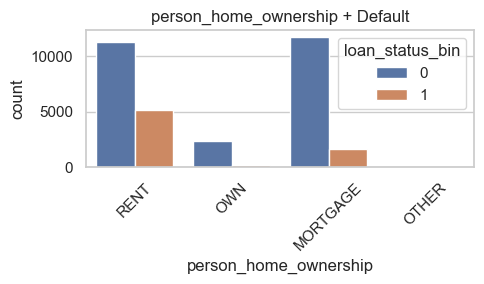


Cross-tab for loan_intent:


loan_status_bin,0,1
loan_intent,,
DEBTCONSOLIDATION,0.714121,0.285879
EDUCATION,0.827832,0.172168
HOMEIMPROVEMENT,0.738974,0.261026
MEDICAL,0.732993,0.267007
PERSONAL,0.801123,0.198877
VENTURE,0.851897,0.148103


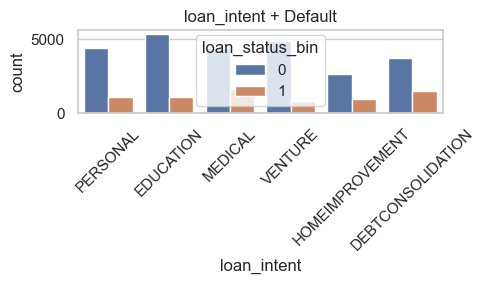


Cross-tab for loan_grade:


loan_status_bin,0,1
loan_grade,,
A,0.900436,0.099564
B,0.837240,0.162760
C,0.792660,0.207340
D,0.409542,0.590458
E,0.355809,0.644191
F,0.294606,0.705394
G,0.015625,0.984375


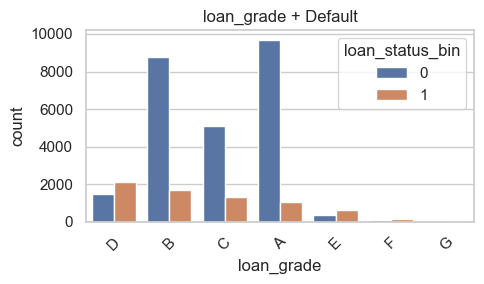

In [19]:
# Ангилал хувьсагч дээр cross-tab (эхний 3 багана жишээ болгож)
cat_cols_for_plot = cat_cols[:3]

for col in cat_cols_for_plot:
    if col in df.columns:
        print(f'\nCross-tab for {col}:')
        display(pd.crosstab(df[col], df[TARGET_BIN_COL], normalize='index'))

        plt.figure(figsize=(5,3))
        sns.countplot(data=df, x=col, hue=TARGET_BIN_COL)
        plt.title(f'{col} + Default')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(f'../outputs/figures/bar_{col}.png')
        plt.show()

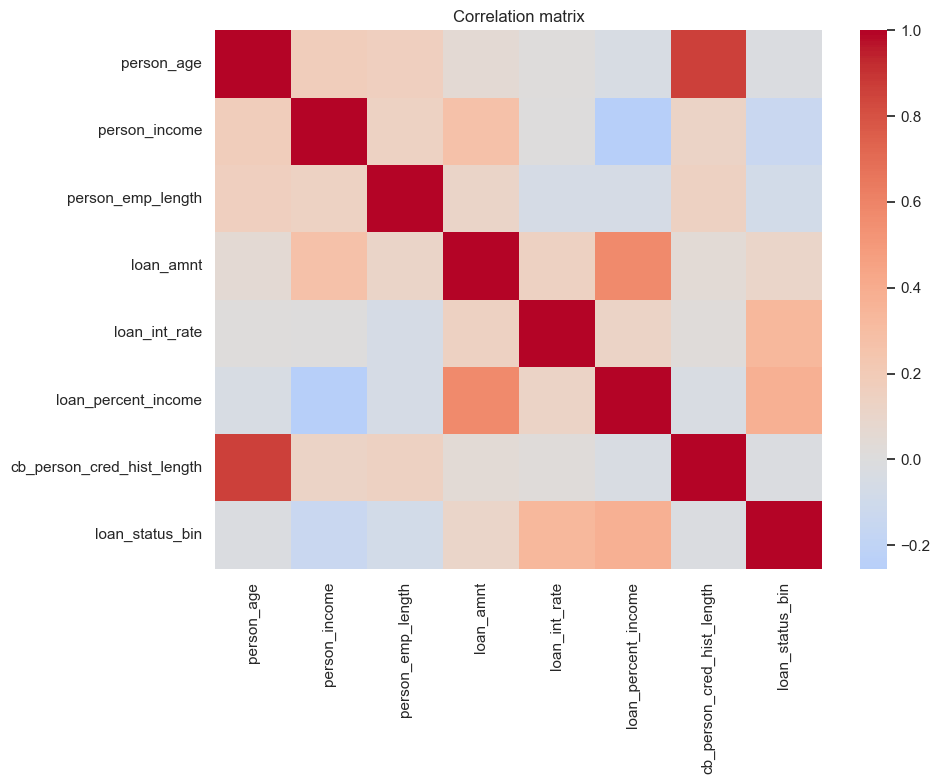

In [20]:
# Корреляцын матриц (тоон баганууд)
if len(num_cols) > 1:
    plt.figure(figsize=(10,8))
    corr = df[num_cols + [TARGET_BIN_COL]].corr()
    sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
    plt.title('Correlation matrix')
    plt.tight_layout()
    plt.savefig('../outputs/figures/corr_matrix.png')
    plt.show()
else:
    print('Correlation matrix-д хангалттай тоон багана алга байна.')

## VI. Naive Bayes модель (GaussianNB)

In [21]:
# Gaussian Naive Bayes модель сургах
nb = GaussianNB()
nb.fit(X_train_scaled, y_train)

y_pred = nb.predict(X_test_scaled)
y_proba = nb.predict_proba(X_test_scaled)[:, 1]

print('Done: Naive Bayes model trained.')

Done: Naive Bayes model trained.


## VII. Naive Bayes-ийн үнэлгээ

In [22]:
# Гол үзүүлэлтүүд
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy : {acc:.4f}')
print(f'Precision: {prec:.4f}')
print(f'Recall   : {rec:.4f}')
print(f'F1-score : {f1:.4f}')

print('\nClassification report:')
print(classification_report(y_test, y_pred))

Accuracy : 0.8252
Precision: 0.6510
Recall   : 0.4290
F1-score : 0.5172

Classification report:
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      5095
           1       0.65      0.43      0.52      1422

    accuracy                           0.83      6517
   macro avg       0.75      0.68      0.71      6517
weighted avg       0.81      0.83      0.81      6517



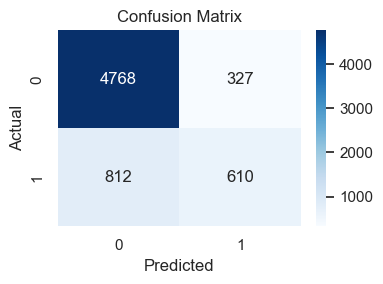

In [23]:
# Confusion matrix дүрслэл
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('../outputs/figures/confusion_matrix.png')
plt.show()

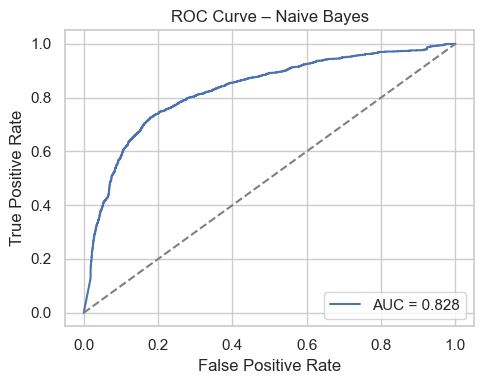

ROC AUC: 0.8276


In [24]:
# ROC крив ба AUC
auc = roc_auc_score(y_test, y_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Naive Bayes')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('../outputs/figures/roc_curve.png')
plt.show()

print(f'ROC AUC: {auc:.4f}')

## VIII. Богино дүгнэлт (QMD тайланд ашиглах ноорог)

- Target классийн баланс: дээрх графикт харуулсан шиг default (1) болон non-default (0)-ийн харьцааг товч тайлбарлана.
- Тоон хувьсагчийн тархалт: орлого, зээлийн хэмжээ, нас гэх мэтээр default өндөр/бага хэсгийг товч дүгнэнэ.
- Naive Bayes-ийн гүйцэтгэл: Accuracy, Recall (ялангуяа default=1 класс), Precision, F1, AUC-гийн талаар 1–2 догол мөрөөр тайлбар бич.

Эдгээр текстийг Хүн B-гийн QMD тайланд шууд хуулж, хүснэгт, графикийг холбож ашиглаж болно.